Import packages

In [1]:
import tensorflow as tf
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import optuna
from optuna.samplers import TPESampler

from tensorflow.keras.layers import LSTM, Dense, Reshape, RepeatVector, Concatenate, Flatten, Dropout
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.losses import MeanAbsolutePercentageError, MeanSquaredError
from tensorflow import transpose, reshape, make_tensor_proto, make_ndarray, convert_to_tensor, float32

Import Financial Data and prepare datasets

In [2]:
symbols = {"BTC-USD", "GOOG", "MSFT", "KCHOL.IS", "BEEF3.SA", "PAM", "CMTOY", "IMP.JO"}

# Pull the data from January 2020 to current date
tickers = yf.Tickers(" ".join(symbols))

# Create a dictionary of Dataframes
hist = {}
for symbol in symbols:
    history = tickers.tickers[symbol].history(start="2020-01-01")
    history.rename(columns={'Open': 'y'}, inplace=True) # fbprophet will detect 'y' column
    history.index.rename('ds', inplace=True) # fbprophet will detect 'ds' dates
    history.reset_index(inplace=True) # Dates are now a column rather than an index (necessary with fbprophet)
    history['ds'] = history['ds'].dt.tz_localize(None)
    hist[symbol] = history

Define the recommender class which will output BUY/SELL/HOLD recommandations based on a Univariate Time Series Forecasting

In [3]:
class recommender():
    ''' 
    Simulates trading of stocks based on the predictions of a statistical tool.
    
    Parameters
    ----------
    initial_stock: Initial stock owned in the simulation
    max_trade: Maximum number of stock units to be traded when a recommendation is made
    intensity: The quantity of stock traded per period is proportional to this parameter
    min_delta: Minimum predicted relative variation of the stock price to 
               recommend a BUY or SELL action.
               
    '''
    def __init__(self,
                 oracle,
                 initial_stock=100, 
                 max_trade = 100, 
                 intensity = 3, 
                 min_delta = 0.05):
        self.initial_stock = initial_stock
        self.max_trade = max_trade
        self.intensity = intensity*max_trade
        self.min_delta = min_delta
        self.seasonal_order = False
        self.oracle = oracle
        
    def __call__(self, args):
        ''' 
        Performs a series of recommendations with the following procedure loop:
        
        1) Fits predictor to the data up to current_date from this iteration 
        2) Makes a prediction of the future stock price (after current_date)
            within a specified timeframe
        3) Makes a recommendation (BUY/SELL/HOLD) based on that prediction
        4) Updates current_date to the last date the prediction covered
    
        This sequence is looped up until a final date is reached.
            
        Parameters
        ----------
        history: 
            pd.DataFrame
            DataFrame with the timeseries data to learn from
        start_date:
            Minimum date up to which the predictor will be fitted
        end_date:
            Last date that the predictions extend to
        interval:
            Number of days separating each prediction point
        periods:
            Integer, predictor is re-fitted to the data up to current date 
            after every "periods" predictions
        
        Returns
        ----------
        A plot of the predictions compared to the real data, the financial
        balance resulting from applying the successive recommendations
        '''
        history, start_date, end_date, periods, interval = args
        
        ## Initiate all the relevant values
        # Basic attributes
        self.stock = self.initial_stock
        initial_price= float(history.loc[(history['ds']-start_date).abs().idxmin()]['y'])
        self.initial_value = self.initial_stock*initial_price # Value of Initial Stock
        self.gains = 0
        
        # Historical attributes
        self.value_history = [] # History of the variation of the value of stock being held
        self.gain_history = [] # History of gains resulting from each successive traded stock
        self.net_gain_history = [] # History of gains resulting from each successive traded stock 
                                    # net of that traded stock value at the next period
                                    # The net gain will be negative if the price of the stock sold increases 
                                    # or if the price of the stock bought decreases
        self.action_history = [] # History of each trading action performed
        
        # Prepare history and self.predictions
        history = history[['ds', 'y']]
        history = history.set_index('ds').squeeze()
        mask = history.index<start_date
        # forecast, prediction, next_date = self.forecast(history, start_date, periods, interval)
        # The way the predictor is fitted to the data will be displayed
        self.predictions = pd.Series(data = []) 
        # Initialization of self.predictions which will be a concatenation of forecasts
        
        # Loop predictions until end_date
        current_date = start_date
        plt.figure()
        plt.axvline(start_date, color = 'b') # Data fitted up to that point
        while current_date < end_date:
            # Fit the predictor to the history of stock prices and forecast
            print(f'{current_date = }')
            forecast, prediction, next_date = self.forecast(history, current_date, periods, interval)
            print(f'{forecast =}')
            print(f'{next_date = }')
            plt.axvline(next_date, color = 'k') # A green vertical line indicates that prediction was made at this date
            self.recommend(history, prediction, current_date, next_date)
            if self.predictions.empty:
                self.predictions = forecast
            else:
                self.predictions = pd.concat([self.predictions, forecast], ignore_index = False)
            # print(f'{self.predictions = }')
            current_date = next_date
        current_price = float(history.iloc[pd.Series(history.index-current_date).abs().idxmin()])
        
        # Next, print all the relevant historical attributes from this recommender to analyze its performance
        self.totalvalue_history = [round(a+b,1) for a,b in zip(self.gain_history, self.value_history)]
        print(f'\nThe Wallet gains per trade is (positive values = SELL)\n{list(zip(self.action_history, self.gain_history))}')
        print(f'\nThe Stock Value gains per trade is\n{list(zip(self.action_history, self.value_history))}')
        print(f'\nStock + Wallet value variation after trading: \n{list(zip(self.action_history, self.totalvalue_history))}')
        print(f'\nStock + Wallet Gains related to stock traded: \n{list(zip(self.action_history, self.net_gain_history))}')
        print(f'with sum of {round(sum(self.net_gain_history), 1)}')
        print(f'\nInitial stock (Quantity = {self.initial_stock}) value on {start_date}: {round(self.initial_value, 1)}')
        print(f'\nInitial stock (Quantity = {self.initial_stock}) value on {end_date}: {round(self.initial_stock*current_price, 1)}')
        print(f'\nFinal stock (Quantity = {round(self.stock, 3)}) value on {end_date}: {round(self.value, 1)}')
        print(f'\nGains from trading: {round(self.gains, 1)}')
        print(f'\nBalance compared to initial stock value on {end_date} (value owned if no trading) = {round(self.gains + self.value - self.initial_stock*current_price,1)}')
        print(f'\nBalance compared to initial stock value on {start_date}: {round(self.gains + self.value - self.initial_value,1)}')
        
        # Plot the predictions compared to real data
        self.MAE, self.error = self.MAE(history, self.predictions, start_date, end_date)
        print(f'\n{self.MAE = }')
        print(f'\n{self.error = }')
        rolling = history.rolling(20)
        mean, std = rolling.mean(), rolling.std()
        bolling_min = pd.Series(mean-2*std)
        bolling_max = pd.Series(mean+2*std)
        plt.title(f'Forecast and real data compared for {symbol}')
        plt.plot(self.predictions, color = 'g', label = 'Predictions')
        plt.plot(history, ':', color = 'k', label = 'History')
        plt.plot(bolling_min, color = 'b', label = 'Top of Bollinger Band')
        plt.plot(bolling_max, color = 'r', label = 'Bottom of Bollinger Band')
        plt.legend()
        plt.xlabel('Date')
        plt.xticks(fontsize = 8) 
        plt.ylabel('Open')
        plt.show()
        
    def recommend(self, history, prediction, current_date, next_date):
        '''
        Performs a trading recommendation based on the predictor's forecast.
        Updates the recommender attributes related to stock held, 
        profit made, and history of recommendations performed.
        
        Arguments
        ----------
        history: Pandas Series, history of stock prices
        prediction: Float, predicted stock price at next date
        current_date: Date up to which stock price data is learned
        next_date: Future date, at which the forecasted stock price 
                    is the basis for the trading recommendation
        
        Updates
        ----------
        self.action_history: List, list of trading actions simulated
        self.stock: Float, simulated stock quantity
        self.value: Float, simulated stock value
        self.gains: Float, simulated gains from stock bought or sold
        self.net: Float, simulated net gains from stock bought or sold
                    (compared to no trading)
        self.value_history: List, subsequent self.value values
        self.gain_history: List, subsequent self.gain values
        self.net_gain_history: List, subsequent self.net values
        '''
        current_price = float(history.iloc[pd.Series(history.index-current_date).abs().idxmin()])
        self.value = self.stock*current_price # Current stock value
        actual_next_price = float(history.iloc[pd.Series(history.index-next_date).abs().idxmin()])
        
        relative = (prediction-current_price)/current_price # Relative price change
        action = ["SELL", "BUY"]
        
        # Determine action to take based on predicted relative price change
        if abs(relative) >= self.min_delta:
            t = prediction/current_price 
            sign = int(t>1/t) - int(t<1/t) # equals 1 if prediction>current_price, else -1
            trade = round(max(-self.stock, min(self.intensity*(max(t, 1/t)-1), self.max_trade)*sign), 6)
                # The amount of stock traded (self.intensity*(max(t, 1/t)-1)) 
                # is higher when a larger price change is predicted
            self.stock += trade
            self.gains -= trade*current_price
            self.net = trade*(actual_next_price-current_price)
            self.action_history.append(action[int(relative>0)]) # BUY or SELL
        else:
            self.net = 0
            self.action_history.append("HOLD")
            trade = 0
    
        # Update value of stock being held
        self.value_history.append(round(self.stock*actual_next_price - self.value,1))
        self.value = self.stock*actual_next_price # Updated stock value
        self.gain_history.append(round(-trade*current_price,1))
        self.net_gain_history.append(round(self.net, 1))
    
    def forecast(self, 
                 history, current_date, 
                 periods, interval):
        '''
        Performs a trading recommendation based on the predictor's forecast.
        Updates the recommender attributes related to stock held, 
        profit made, and history of recommendations performed.
        
        Arguments
        ----------
        history: Pandas Series, history of stock prices
        current_date: Date up to which stock price data is learned
        periods: Integer, number of predictions
        interval: Integer, number of days between each prediction
        
        Returns
        ----------
        forecast: Pandas series, with stock price predictions
        prediction: Float, last stock price prediction
        next_date: Date at which the last stock price is predicted
        '''
        
        oracle = self.oracle
        forecast, prediction, next_date = oracle(history,
                                                 current_date,
                                                 periods,
                                                 interval)
        return forecast, prediction, next_date

    def MAE(self, history, forecast, start_date, end_date):
        '''Returns the Mean Absolute Error of the forecast'''
        hmask = (history.index >= start_date) & (history.index <= end_date)
        fmask = (forecast.index >= start_date) & (forecast.index <= end_date)
        error = history[hmask].subtract(forecast[fmask]).abs().dropna()
        return round(error.mean(), 1), error

Define the forecaster class which works with Long Short Term Memory units

In [4]:
class forecaster():
    '''
    Forecasts stock prices based on historical data.
    
    Parameters
    ----------
    model_name: String, model chosen for forecasting
    args: Defaultdict(int), contains arguments for the model definition
    '''
    def __init__(self, model_name, args = defaultdict(int)):
        if model_name.lower() == 'lstm':
            self.model_name = 'lstm'
            
            # Define the LSTM layer
            n_a = args['n_a']
            if n_a == 0:
                n_a = 32; args['n_a'] = n_a
            stateful = bool(args['stateful']); args['stateful'] = stateful
            LSTM_layer = LSTM(n_a, 
                              activation = 'relu', 
                              return_state = True, 
                              return_sequences = False,
                              stateful = stateful, 
                              name = 'LSTM_layer')
            # The stateful mode can be activated to find dependencies between input sequences:
            # The last state for each sample at index i in a batch will be used 
            # as initial state for the sample of index i in the following batch.
            # In that case, batch_size needs to be 1.
            
            # Define the Dense layer
            include_dates = bool(args['include_dates']); args['include_dates'] = include_dates
            n_features = min(args['n_features'], 1+int(include_dates)); args['n_features'] = n_features
            dense = Dense(n_features, 
                          activation = 'relu', 
                          name = 'Dense_layer')
            
            # Create the model
            batch_size = 32 - 31*int(stateful) # 32 or 1 if stateful mode on
            self.batch_size = batch_size
            seq_len = args['seq_len']
            if seq_len == 0:
                print("Warning: argument 'seq_len' was not specified in the args defaultdict\n")
                print("The sequence length of the training examples fed into the LSTM will be set to 60 by default\n")
                seq_len = 60; args['seq_len'] = seq_len
            self.model = self.LSTM_model(seq_len,
                                         n_features,
                                         LSTM_layer, 
                                         dense)
            
            # Define the various custom losses that may be selected
            def huber_loss(y_true, y_pred, delta=1.0):
                error = y_true - y_pred
                quadratic_term = tf.minimum(tf.abs(error), delta)
                linear_term = tf.abs(error) - quadratic_term
                return 0.5 * tf.square(quadratic_term) + delta * linear_term

            def quantile_loss(q, y_true, y_pred):
                error = y_true - y_pred
                return K.mean(K.maximum(q * error, (q - 1) * error), axis=-1)
            
            def logcosh_loss(y_true, y_pred):
                log_pred = K.log(y_pred + K.epsilon())
                log_true = K.log(y_true + K.epsilon())
                loss = K.mean(K.log(K.cosh(log_pred - log_true) + K.epsilon()), axis=-1)
                return loss

            def log_loss(y_true, y_pred):
                error = y_true - y_pred
                return K.mean(K.log(1 + K.abs(error)), axis=-1)
            
            # Select the loss
            loss = args['loss']
            if loss in {'huber', 'quantile', 'logcosh', 'log'}:
                loss = loss + '_loss'
            loss_set = {'huber_loss', 'quantile_loss', 'logcosh_loss', 'log_loss',
                        'mean_squared_error', 'mse', 'mean_absolute_error', 'mae', 
                        'mean_absolute_percentage_error', 'mape'
                       }
            if loss not in loss_set:
                print('The loss was either not specified or not supported by this recommender.\n')
                print(f'Supported losses are {loss_set}\n')
                print('Loss will be set by default to the huber loss\n')
                loss = 'huber_loss'
            args['loss'] = loss
            
            # Compile the model
            learning_rate = args['learning_rate']
            if learning_rate == 0:
                learning_rate = 0.01; args['learning_rate'] = learning_rate
            decay = args['decay']
            if decay == 0:
                decay = 0.99; args['decay'] = decay
            self.model.compile(loss = loss, #huber loss, log cost, quantile loss fn
                               optimizer = Adam(learning_rate = learning_rate,
                                                beta_1=0.9, 
                                                beta_2=0.999,
                                                decay=decay, 
                                                amsgrad=False),
                               metrics = ['mean_absolute_error'])
            self.args = args
            # print(self.model.summary())
    
    def __call__(self, 
                 history, current_date, 
                 periods, interval):
        '''
        Fits the forecaster's model to the data up to current_date.
        Then, performs a forecast every {interval} days, {periods} times.
        
        Arguments
        ----------
            history: Pandas series, time series the model will be fitted to.
            current_date: Until that date, the model will be fitted to the data.
            interval: Integer, number of days between each prediction
            periods: Integer, number of predictions
        
        Returns
        ----------
            forecast: A pandas series with forecast dates as indexes and corresponding forecast values.
        '''
        # Extract the data to fit the model to
        to_fit = history[history.index<=current_date]
        if self.model_name == 'lstm':
            LSTM_layer, dense, scaler, inputs = self.fit_LSTM(to_fit)
            
            forecast = self.predict_LSTM(inputs,
                                         scaler,
                                         LSTM_layer,
                                         dense,
                                         current_date,
                                         interval,
                                         periods)

            prediction = forecast.iloc[-1] # Predicted future stock price
            next_date = forecast.index[-1]

            return forecast, prediction, next_date
    
    def LSTM_model(self,
                   seq_len, n_features,
                   LSTM_layer, dense):
        '''
        Returns the LSTM model that is composed of a LSTM layer followed
        by a Dense layer.
        
        Arguments:
            seq_len: Sequence length of each training example
            n_features: Number of features in each training example
            LSTM_layer: An LSTM layer instance
            dense: A Dense layer instance
        
        Returns:
            model: The model instance.
        '''
        n_a = LSTM_layer.units
        
        X = Input(batch_shape = (self.batch_size, seq_len, n_features))
        
        a0 = Input(batch_shape = (self.batch_size, n_a), name = 'a0')
        c0 = Input(batch_shape = (self.batch_size, n_a), name = 'c0')
        
        a = a0
        c = c0
        
        outputs_h = []
        
        # for step in range(seq_len):
            # x = X[:, step, :] # shape = (None, n_features)
            # x = Reshape([1, n_features])(x) # shape = (None, 1, n_features)
            # _, a, c = LSTM_layer(inputs = x, initial_state = [a, c])
            
        _, a, c = LSTM_layer(inputs = X, initial_state = [a, c])
        
        a = Dropout(0.1)(a)
        
        outputs = Reshape([n_features])(dense(a)) # shape = (None, n_features)
        model = Model(inputs = [X, a0, c0], outputs = outputs)
        return model
    
    def fit_LSTM(self, to_fit):
        '''
        Fits the forecaster's model.
        
        Arguments:
            to_fit: Time series with data the model will be fitted to.
            
        Returns:
            LSTM_layer: A trained LSTM layer
            dense: A trained Dense layer
            scaler: A Scaler that has been fitted to the data
            inputs: A list containing
                x0: Array, sequence that follows the last labeled sequence.
                    Will be used as an input to predict_LSTM
                a0: Array, initial LSTM hidden state
                c0: Array, initial LSTM cell state
        '''
        args = self.args
        
        # Whether the time series will be differenced to make the time series stationary
        if bool(args['difference']): 
            to_fit = to_fit.diff().fillna(method='ffill').fillna(method='bfill')
        
        # Normalize the stock price values
        # scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = RobustScaler()
        normalized_data = scaler.fit_transform(to_fit.values.reshape(-1, 1))
        
        # Transform the time series data into a 3D structure adapted to LSTMs
        seq_len = args['seq_len']
        m = len(normalized_data) - seq_len # Number of samples
        extra_m = m%self.batch_size
        m = m-extra_m
        # print(f'{m = }')
        to_fit = to_fit.iloc[extra_m:]
        normalized_data = normalized_data[extra_m:]
        n_features = min(args['n_features'], 1)
        include_dates = bool(args['include_dates'])
        reference_date = to_fit.index[0] # Most ancient date 
        X = np.zeros((m, seq_len, n_features)) # shape = (samples, n_timesteps, n_features)
        Y = np.zeros((m, int(include_dates)+1)) # shape = (samples, 1 or 2)
        for i in range(m):
            if include_dates:
                dates = to_fit.index[i:i+seq_len]
                for j in range(len(dates)):
                    X[i, j, 0] = (dates[j]-reference_date).days
                Y[i, 0] = to_fit.index[i+seq_len]
            sequence = normalized_data[i:i+seq_len]
            for j, data_point in enumerate(sequence):
                X[i, j, int(include_dates):] = sequence[j]
            Y[i, int(include_dates)] = normalized_data[i+seq_len][0]
            # The feature to predict is the first feature
            
        # print(f'{(X[0], Y[0]) = }')
        # print(f'{(X.shape, Y.shape) = }')
        
        # Prepare x0 for future use as an input to predict_LSTM
        x0 = X[-1:, :, :]; y = Y[-1, 0] # The last sequence will concatenate these elements
        x0 = x0[:, 1:, :] # remove left side element
        y = np.reshape([y], (1, 1, 1)) # define right side element
        x0 = np.concatenate((x0, y), axis = 1) # append right side element
        
        ## Prepare and fit the LSTM model
        n_a = args['n_a']
        a0, c0 = np.zeros((m, n_a)), np.zeros((m, n_a))
        # print(f'{(X.shape, Y.shape) = }')
        batch_size = 32; shuffle = True
        if bool(args['stateful']):
            batch_size = 1
            shuffle = False
        epochs = args['epochs']
        if epochs == 0:
            epochs = 50
        
        self.model.fit([X, a0, c0], 
                       Y, 
                       epochs = epochs, 
                       batch_size = batch_size, 
                       shuffle = shuffle, 
                       verbose = 1)
        
        if args['stateful']:
            # Do a forward pass on sequences in chronological order
            # The hidden states and cell states will be retrieved after
            self.model.predict([X, a0, c0], batch_size = 1)
            LSTM_layer = self.model.get_layer(name='LSTM_layer')
            a0, c0 = LSTM_layer.states
            # print(f'{(a0, c0) = }')
        
        LSTM_layer = self.model.get_layer(name='LSTM_layer') # Trained LSTM layer
        dense = self.model.get_layer(name='Dense_layer') # Trained dense layer
        
        inputs = [x0[0:1], a0[-1:], c0[-1:]]
        # print(f'x0 unscaled = {scaler.inverse_transform(x0[0])}')
        
        return LSTM_layer, dense, scaler, inputs
    
    def predict_LSTM(self,
                     inputs,
                     scaler,
                     LSTM_layer,
                     dense,
                     current_date,
                     interval,
                     periods):
        '''    
        Generates a sequence of predicted stock values.

        Arguments:
        inputs: A list containing the model's inputs [x0, a0, x0]
        scaler: Scaler that has been fitted to the data
        LSTM_layer: A trained LSTM layer
        dense: A trained dense layer
        current_date: Date after which predicitions will be made
        interval: Integer, number of days between each predicition
        periods: Integer, number of predictions

        Returns:
        forecast: Pandas series with the forecast
        '''
        args = self.args
        x0, a0, c0 = inputs
        # Instantiate the predictor
        predictor = self.predictor_model(LSTM_layer,
                                         dense,
                                         interval,
                                         periods)

        # Predictor is now fitted to data prior to current_date
        # print(x0.shape, a0.shape, c0.shape)
        pred = predictor.predict_on_batch([x0, a0, c0])
        # print(f'{x0 = }')
        # print(f'{pred = }')
        
        if args['include_dates']:
            dates = [current_date + pd.Timedelta(int(pred[p][0]), 'D') for p in range(len(pred))]
            y = [value[1] for value in pred]
        else:
            dates = [current_date + (p+1)*pd.Timedelta(interval, 'D') for p in range(len(pred))]
            y = [value[0] for value in pred]
        
        if bool(args['difference']):
            y = np.cumsum(np.concatenate(([last_price], y)))[1:] # Integrate
        
        # print(f'{y = }')
        y = scaler.inverse_transform(np.reshape(y, (-1, 1)))[:, 0]
        # print(f'{y = }')

        forecast = pd.DataFrame(data = {'y': y, 'ds': dates}).set_index('ds').squeeze()
        # print(forecast)
        
        return forecast
    
    def predictor_model(self, 
                        LSTM_layer, 
                        dense,
                        interval,
                        periods):
        '''    
        Returns a model to generate a sequence of stock price predictions.

        Arguments:
        LSTM_layer: A trained LSTM layer
        dense: A trained dense layer
        interval: Integer, number of days between each prediction
        periods: Integer, number of successive predictions

        Returns:
        predictor: The predictor model instance
        '''
        n_a = LSTM_layer.units
        
        args = self.args
        seq_len = args['seq_len']; n_features = args['n_features'] 
        
        x0 = Input(batch_shape = (1, seq_len, n_features))
        a0 = Input(batch_shape = (1, n_a), name = 'a0')
        c0 = Input(batch_shape = (1, n_a), name = 'c0')
        
        x, a, c = x0, a0, c0
        
        outputs = []
        
        day_count = 0
        
        while day_count < interval*periods:
            _, a, c = LSTM_layer(inputs = x, initial_state = [a, c])
            # print(f'{a = }')
            new_day_count = day_count + 1
            if (new_day_count+2)//7 == 0:
                new_day_count += 2 # Weekend stock prices not included in the time series training data
            output = Reshape([1, n_features])(dense(a)) # shape = (batch size, 1, n_features)
            # print(f'{output.shape = }')
            if new_day_count//interval > day_count//interval:
                outputs.append(output[0, 0]) # output is remembered every interval days
            day_count = new_day_count
            x = Concatenate(axis=1)([x[:, 1:, :], output]) 
            # print(f'{x.shape = }')
        
        predictor = Model(inputs = [x0, a0, c0], outputs = outputs)
        
        return predictor

Choose what to forecast

In [5]:
symbols = ["BTC-USD", "GOOG", "MSFT", "KCHOL.IS", "BEEF3.SA", "PAM", "CMTOY", "IMP.JO"]
symbol = symbols[2]
history = hist[symbol]

Set the stock parameters

In [6]:
initial_stock = 10
max_trade = 10 # Maximum units of stock that can be traded after 1 recommendation is made
intensity = 3 # Price variation by 1/intensity results in trading max_trade
min_delta = 0.01 # Minimum predicted relative variation of stock price to perform a SELL or BUY action (0<min_delta<1)

Define the validation timerange for hyperparameter tuning

In [7]:
start_date = pd.to_datetime('2023-05-01') # Predictions begin after this date
end_date = pd.to_datetime('2023-08-01') # Predictions end after this date

interval = 7 # in days
periods = 2 # A recommendation is made every periods*interval days

Define how to perform an optuna search of the hyperparameters

In [8]:
def optuna_search(n_trials,
                  n_a_list = [2**i for i in range(5, 8)],
                  lr_range = (0.001, 0.01),
                  seq_len_range = (60, 180),
                  decay = 0.99, 
                  epochs = 10, 
                  stateful = False, 
                  difference = False):
    '''
    Performs a hyperparameter optimization using optuna.
    The parameters tested are the number of LSTM units n_a, 
    the sequence length seq_len and the learning rate.
    
    Arguments:
        n_trials: Integer, how many sets of parameters will be tested
        decay: Float, learning rate decay
        epochs: Integer, number of training epochs
        stateful: Boolean, whether the LSTM stateful mode is on
        difference: Boolean, whether to difference the time series
    
    Returns:
        n_a: Integer, number of LSTM units
        learning_rate: Float, learning rate
        seq_len: Integer, sequence length
    
    '''
    def objective(trial):
        n_a = trial.suggest_categorical("n_a", n_a_list)
        learning_rate = trial.suggest_float("learning_rate", lr_range[0], lr_range[1], log=True)
        seq_len = trial.suggest_int("seq_len", seq_len_range[0], seq_len_range[1])
        arguments = {'seq_len': seq_len,
                     'n_features': 1,
                     'learning_rate': learning_rate,
                     'loss': 'huber',
                     'decay': decay,
                     'epochs': epochs,
                     'n_a': n_a,
                     'include_dates': False,
                     'stateful': stateful,
                     'difference': difference}
        args = defaultdict(int)
        for key, value in arguments.items():
            args[key] = value
        clairvoyant = forecaster('LSTM', args)
        recommend = recommender(oracle = clairvoyant,
                                initial_stock = initial_stock, 
                                max_trade = max_trade,
                                intensity = intensity,
                                min_delta = min_delta)
        args = (history, start_date, end_date, periods, interval)
        recommend(args) # performs the recommendation
        MAE, error = recommend.MAE, recommend.error
        return MAE
    
    sampler = TPESampler(seed=0)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials = n_trials)
    print("\nNumber of finished trials: ", len(study.trials))
    print("Best trial:")
    best_trial = study.best_trial
    print("  MAE: ", best_trial.value)
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    n_a = best_trial.params['n_a']
    learning_rate = best_trial.params['learning_rate']
    seq_len = best_trial.params['seq_len']
    return n_a, learning_rate, seq_len

Run with stateful = False

[I 2023-11-26 22:45:50,974] A new study created in memory with name: no-name-173646f1-8152-4c17-abfd-eba3bee16c4b


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/10
22/22 [==============================] - 3s 68ms/step - loss: 0.0960 - mean_absolute_error: 0.3571
Epoch 2/10
22/22 [==============================] - 2s 76ms/step - loss: 0.0696 - mean_absolute_error: 0.3047
Epoch 3/10
22/22 [==============================] - 2s 73ms/step - loss: 0.0602 - mean_absolute_error: 0.2833
Epoch 4/10
22/22 [==============================] - 2s 78ms/step - loss: 0.0541 - mean_absolute_error: 0.2659
Epoch 5/10
22/22 [==============================] - 2s 71ms/step - loss: 0.0503 - mean_absolute_error: 0.2549
Epoch 6/10
22/22 [==============================] - 2s 76ms/step - loss: 0.0464 - mean_absolute_error: 0.2427
Epoch 7/10
22/22 [==============================] - 2s 72ms/step - loss: 0.0422 - mean_absolute_error: 0.2278
Epoch 8/10
22/22 [==============================] - 2s 71ms/step - loss: 0.0411 - mean_absolute_error: 0.2226
Epoch 9/10
22/22 [==============================] - 2s 69ms/step - loss:

24/24 [==============================] - 2s 71ms/step - loss: 0.0393 - mean_absolute_error: 0.2075
forecast =ds
2023-07-17    341.748077
2023-07-24    352.184937
Name: y, dtype: float32
next_date = Timestamp('2023-07-24 00:00:00')
current_date = Timestamp('2023-07-24 00:00:00')
Epoch 1/10
24/24 [==============================] - 2s 70ms/step - loss: 0.0388 - mean_absolute_error: 0.2074
Epoch 2/10
24/24 [==============================] - 2s 76ms/step - loss: 0.0376 - mean_absolute_error: 0.2012
Epoch 3/10
24/24 [==============================] - 2s 81ms/step - loss: 0.0385 - mean_absolute_error: 0.2056
Epoch 4/10
24/24 [==============================] - 2s 76ms/step - loss: 0.0389 - mean_absolute_error: 0.2072
Epoch 5/10
24/24 [==============================] - 2s 77ms/step - loss: 0.0383 - mean_absolute_error: 0.2049
Epoch 6/10
24/24 [==============================] - 2s 78ms/step - loss: 0.0388 - mean_absolute_error: 0.2069
Epoch 7/10
24/24 [==============================] - 2s 75ms/s

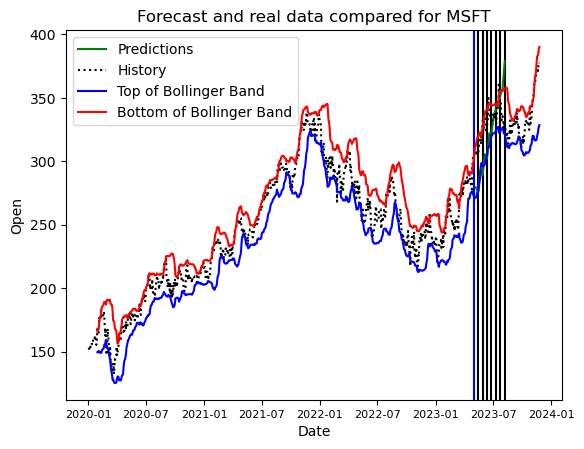

[I 2023-11-26 22:48:15,392] Trial 0 finished with value: 17.3 and parameters: {'n_a': 64, 'learning_rate': 0.003506575410186656, 'seq_len': 111}. Best is trial 0 with value: 17.3.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/10
22/22 [==============================] - 6s 207ms/step - loss: 354211616.0000 - mean_absolute_error: 354211616.0000
Epoch 2/10
22/22 [==============================] - 4s 204ms/step - loss: 27740.5762 - mean_absolute_error: 27740.8008
Epoch 3/10
22/22 [==============================] - 4s 201ms/step - loss: 0.2204 - mean_absolute_error: 0.4027
Epoch 4/10
22/22 [==============================] - 4s 200ms/step - loss: 0.0389 - mean_absolute_error: 0.2120
Epoch 5/10
22/22 [==============================] - 4s 174ms/step - loss: 0.0387 - mean_absolute_error: 0.2112
Epoch 6/10
22/22 [==============================] - 5s 207ms/step - loss: 0.0381 - mean_absolute_error: 0.2075
Epoch 7/10
22/22 [==============================] - 4s 189ms/step - loss: 0.0384 - mean_absolute_error: 0.2096
Epoch 8/10
22/22 [==============================] - 5s 206ms/step - loss: 0.0383 - mean_absolute_error: 0.2095
Epoch 9/10
22/22 [======================

24/24 [==============================] - 6s 238ms/step - loss: 0.0385 - mean_absolute_error: 0.2070
Epoch 5/10
24/24 [==============================] - 5s 228ms/step - loss: 0.0388 - mean_absolute_error: 0.2074
Epoch 6/10
24/24 [==============================] - 5s 220ms/step - loss: 0.0387 - mean_absolute_error: 0.2079
Epoch 7/10
24/24 [==============================] - 5s 221ms/step - loss: 0.0389 - mean_absolute_error: 0.2096
Epoch 8/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0388 - mean_absolute_error: 0.2081
Epoch 9/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0386 - mean_absolute_error: 0.2074
Epoch 10/10
24/24 [==============================] - 5s 223ms/step - loss: 0.0391 - mean_absolute_error: 0.2094
forecast =ds
2023-07-31    366.421600
2023-08-07    406.035339
Name: y, dtype: float32
next_date = Timestamp('2023-08-07 00:00:00')

The Wallet gains per trade is (positive values = SELL)
[('SELL', 668.5), ('SELL', 246.2), ('SELL', 6

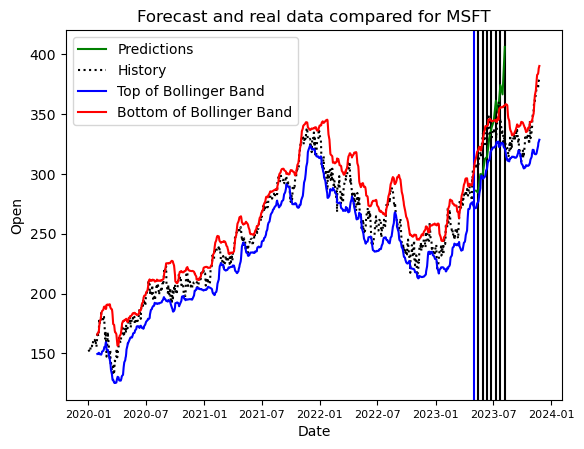

[I 2023-11-26 22:55:10,503] Trial 1 finished with value: 18.6 and parameters: {'n_a': 128, 'learning_rate': 0.009197350992568125, 'seq_len': 106}. Best is trial 0 with value: 17.3.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/10
24/24 [==============================] - 2s 33ms/step - loss: 0.0801 - mean_absolute_error: 0.2971
Epoch 2/10
24/24 [==============================] - 1s 29ms/step - loss: 0.0664 - mean_absolute_error: 0.2572
Epoch 3/10
24/24 [==============================] - 1s 31ms/step - loss: 0.0661 - mean_absolute_error: 0.2546
Epoch 4/10
24/24 [==============================] - 1s 29ms/step - loss: 0.0665 - mean_absolute_error: 0.2539
Epoch 5/10
24/24 [==============================] - 1s 29ms/step - loss: 0.0658 - mean_absolute_error: 0.2517
Epoch 6/10
24/24 [==============================] - 1s 28ms/step - loss: 0.0658 - mean_absolute_error: 0.2518
Epoch 7/10
24/24 [==============================] - 1s 28ms/step - loss: 0.0655 - mean_absolute_error: 0.2517
Epoch 8/10
24/24 [==============================] - 1s 30ms/step - loss: 0.0660 - mean_absolute_error: 0.2507
Epoch 9/10
24/24 [==============================] - 1s 30ms/step - loss:

25/25 [==============================] - 1s 34ms/step - loss: 0.0500 - mean_absolute_error: 0.2211
Epoch 6/10
25/25 [==============================] - 1s 35ms/step - loss: 0.0505 - mean_absolute_error: 0.2238
Epoch 7/10
25/25 [==============================] - 1s 31ms/step - loss: 0.0508 - mean_absolute_error: 0.2262
Epoch 8/10
25/25 [==============================] - 1s 34ms/step - loss: 0.0504 - mean_absolute_error: 0.2245
Epoch 9/10
25/25 [==============================] - 1s 36ms/step - loss: 0.0503 - mean_absolute_error: 0.2215
Epoch 10/10
25/25 [==============================] - 1s 35ms/step - loss: 0.0499 - mean_absolute_error: 0.2211
forecast =ds
2023-07-31    351.227112
2023-08-07    360.349274
Name: y, dtype: float32
next_date = Timestamp('2023-08-07 00:00:00')

The Wallet gains per trade is (positive values = SELL)
[('SELL', 689.7), ('SELL', 277.6), ('SELL', 728.5), ('HOLD', 0.0), ('BUY', -213.2), ('BUY', -186.9), ('BUY', -477.9)]

The Stock Value gains per trade is
[('SELL'

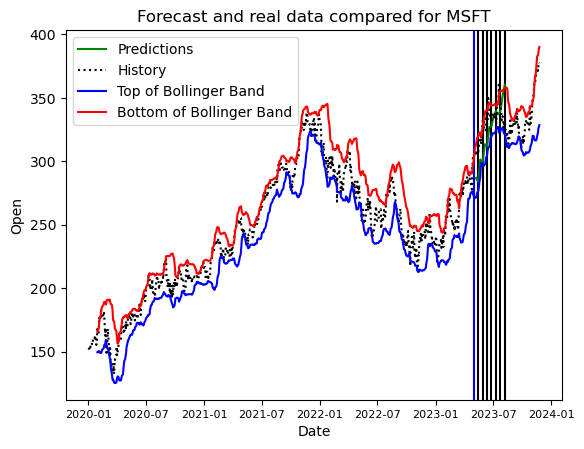

[I 2023-11-26 22:56:36,443] Trial 2 finished with value: 12.5 and parameters: {'n_a': 32, 'learning_rate': 0.008425518534432113, 'seq_len': 68}. Best is trial 2 with value: 12.5.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/10
21/21 [==============================] - 8s 329ms/step - loss: 0.0418 - mean_absolute_error: 0.2210
Epoch 2/10
21/21 [==============================] - 7s 333ms/step - loss: 0.0309 - mean_absolute_error: 0.1886
Epoch 3/10
21/21 [==============================] - 7s 335ms/step - loss: 0.0291 - mean_absolute_error: 0.1794
Epoch 4/10
21/21 [==============================] - 7s 327ms/step - loss: 0.0287 - mean_absolute_error: 0.1769
Epoch 5/10
21/21 [==============================] - 8s 357ms/step - loss: 0.0283 - mean_absolute_error: 0.1750
Epoch 6/10
21/21 [==============================] - 7s 342ms/step - loss: 0.0280 - mean_absolute_error: 0.1729
Epoch 7/10
21/21 [==============================] - 7s 340ms/step - loss: 0.0283 - mean_absolute_error: 0.1747
Epoch 8/10
21/21 [==============================] - 7s 338ms/step - loss: 0.0279 - mean_absolute_error: 0.1715
Epoch 9/10
21/21 [==============================] - 7s 332ms/ste

22/22 [==============================] - 7s 323ms/step - loss: 0.0232 - mean_absolute_error: 0.1537
Epoch 5/10
22/22 [==============================] - 7s 340ms/step - loss: 0.0231 - mean_absolute_error: 0.1524
Epoch 6/10
22/22 [==============================] - 7s 321ms/step - loss: 0.0235 - mean_absolute_error: 0.1568
Epoch 7/10
22/22 [==============================] - 7s 324ms/step - loss: 0.0233 - mean_absolute_error: 0.1551
Epoch 8/10
22/22 [==============================] - 7s 319ms/step - loss: 0.0233 - mean_absolute_error: 0.1548
Epoch 9/10
22/22 [==============================] - 7s 328ms/step - loss: 0.0233 - mean_absolute_error: 0.1557
Epoch 10/10
22/22 [==============================] - 8s 345ms/step - loss: 0.0232 - mean_absolute_error: 0.1549
forecast =ds
2023-07-31    350.824860
2023-08-07    357.643585
Name: y, dtype: float32
next_date = Timestamp('2023-08-07 00:00:00')

The Wallet gains per trade is (positive values = SELL)
[('SELL', 583.7), ('SELL', 124.4), ('SELL', 5

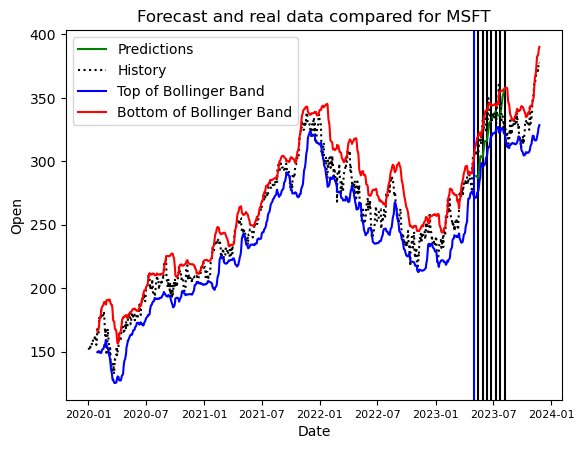

[I 2023-11-26 23:05:42,080] Trial 3 finished with value: 11.0 and parameters: {'n_a': 128, 'learning_rate': 0.006000075993611755, 'seq_len': 165}. Best is trial 3 with value: 11.0.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/10
23/23 [==============================] - 2s 34ms/step - loss: 0.1315 - mean_absolute_error: 0.4210
Epoch 2/10
23/23 [==============================] - 1s 34ms/step - loss: 0.1099 - mean_absolute_error: 0.3831
Epoch 3/10
23/23 [==============================] - 1s 33ms/step - loss: 0.0974 - mean_absolute_error: 0.3609
Epoch 4/10
23/23 [==============================] - 1s 34ms/step - loss: 0.0898 - mean_absolute_error: 0.3463
Epoch 5/10
23/23 [==============================] - 1s 33ms/step - loss: 0.0834 - mean_absolute_error: 0.3330
Epoch 6/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0785 - mean_absolute_error: 0.3231
Epoch 7/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0713 - mean_absolute_error: 0.3056
Epoch 8/10
23/23 [==============================] - 1s 34ms/step - loss: 0.0654 - mean_absolute_error: 0.2887
Epoch 9/10
23/23 [==============================] - 1s 37ms/step - loss:

25/25 [==============================] - 1s 34ms/step - loss: 0.0580 - mean_absolute_error: 0.2597
Epoch 6/10
25/25 [==============================] - 1s 34ms/step - loss: 0.0576 - mean_absolute_error: 0.2595
Epoch 7/10
25/25 [==============================] - 1s 33ms/step - loss: 0.0578 - mean_absolute_error: 0.2590
Epoch 8/10
25/25 [==============================] - 1s 32ms/step - loss: 0.0572 - mean_absolute_error: 0.2581
Epoch 9/10
25/25 [==============================] - 1s 32ms/step - loss: 0.0574 - mean_absolute_error: 0.2588
Epoch 10/10
25/25 [==============================] - 1s 33ms/step - loss: 0.0578 - mean_absolute_error: 0.2606
forecast =ds
2023-07-31    3.687761e+02
2023-08-07    3.594675e+14
Name: y, dtype: float32
next_date = Timestamp('2023-08-07 00:00:00')

The Wallet gains per trade is (positive values = SELL)
[('SELL', 1376.1), ('SELL', 1087.1), ('SELL', 650.8), ('SELL', 0.0), ('HOLD', 0.0), ('BUY', -858.1), ('BUY', -3444.2)]

The Stock Value gains per trade is
[('

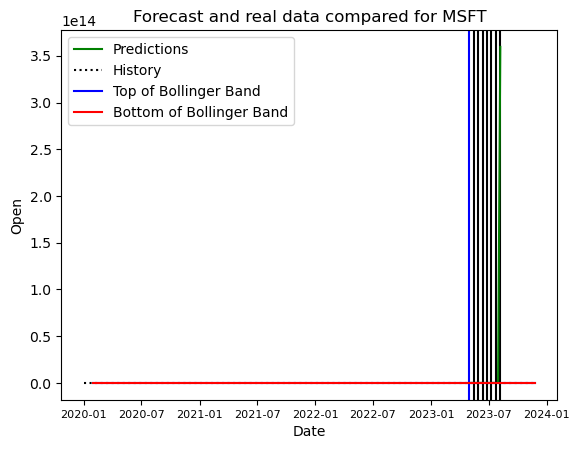

[I 2023-11-26 23:07:08,006] Trial 4 finished with value: 27.7 and parameters: {'n_a': 32, 'learning_rate': 0.006032942364042933, 'seq_len': 74}. Best is trial 3 with value: 11.0.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/10
22/22 [==============================] - 7s 242ms/step - loss: 0.0781 - mean_absolute_error: 0.3192
Epoch 2/10
22/22 [==============================] - 5s 249ms/step - loss: 0.0420 - mean_absolute_error: 0.2288
Epoch 3/10
22/22 [==============================] - 6s 265ms/step - loss: 0.0393 - mean_absolute_error: 0.2174
Epoch 4/10
22/22 [==============================] - 4s 175ms/step - loss: 0.0384 - mean_absolute_error: 0.2132
Epoch 5/10
22/22 [==============================] - 6s 256ms/step - loss: 0.0381 - mean_absolute_error: 0.2120
Epoch 6/10
22/22 [==============================] - 6s 251ms/step - loss: 0.0377 - mean_absolute_error: 0.2102
Epoch 7/10
22/22 [==============================] - 6s 258ms/step - loss: 0.0373 - mean_absolute_error: 0.2078
Epoch 8/10
22/22 [==============================] - 6s 271ms/step - loss: 0.0376 - mean_absolute_error: 0.2089
Epoch 9/10
22/22 [==============================] - 6s 268ms/ste

24/24 [==============================] - 6s 261ms/step - loss: 0.0373 - mean_absolute_error: 0.1988
Epoch 5/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0374 - mean_absolute_error: 0.2000
Epoch 6/10
24/24 [==============================] - 7s 271ms/step - loss: 0.0374 - mean_absolute_error: 0.1999
Epoch 7/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0371 - mean_absolute_error: 0.1985
Epoch 8/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0371 - mean_absolute_error: 0.1974
Epoch 9/10
24/24 [==============================] - 7s 271ms/step - loss: 0.0373 - mean_absolute_error: 0.1997
Epoch 10/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0373 - mean_absolute_error: 0.2002
forecast =ds
2023-07-31    350.729614
2023-08-07    359.409729
Name: y, dtype: float32
next_date = Timestamp('2023-08-07 00:00:00')

The Wallet gains per trade is (positive values = SELL)
[('SELL', 830.7), ('SELL', 411.2), ('SELL', 7

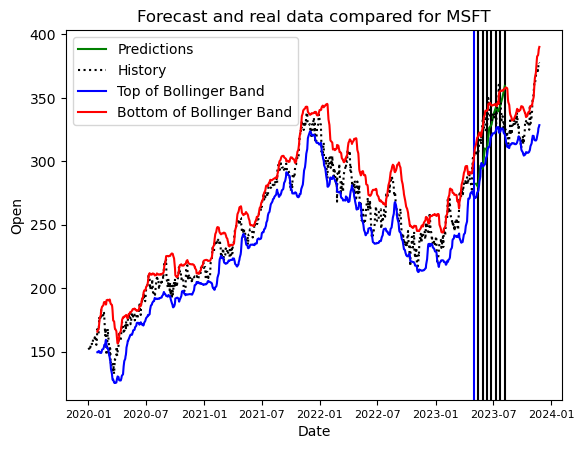

[I 2023-11-26 23:14:26,625] Trial 5 finished with value: 13.6 and parameters: {'n_a': 128, 'learning_rate': 0.003325433915400586, 'seq_len': 110}. Best is trial 3 with value: 11.0.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/10
24/24 [==============================] - 3s 50ms/step - loss: 0.1177 - mean_absolute_error: 0.3946
Epoch 2/10
24/24 [==============================] - 1s 48ms/step - loss: 0.0926 - mean_absolute_error: 0.3442
Epoch 3/10
24/24 [==============================] - 1s 52ms/step - loss: 0.0824 - mean_absolute_error: 0.3173
Epoch 4/10
24/24 [==============================] - 1s 48ms/step - loss: 0.0746 - mean_absolute_error: 0.2935
Epoch 5/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0724 - mean_absolute_error: 0.2853
Epoch 6/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0718 - mean_absolute_error: 0.2822
Epoch 7/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0718 - mean_absolute_error: 0.2810
Epoch 8/10
24/24 [==============================] - 1s 47ms/step - loss: 0.0716 - mean_absolute_error: 0.2806
Epoch 9/10
24/24 [==============================] - 1s 47ms/step - loss:

26/26 [==============================] - 1s 54ms/step - loss: 0.0715 - mean_absolute_error: 0.2661
Epoch 6/10
26/26 [==============================] - 2s 62ms/step - loss: 0.0725 - mean_absolute_error: 0.2714
Epoch 7/10
26/26 [==============================] - 1s 57ms/step - loss: 0.0725 - mean_absolute_error: 0.2726
Epoch 8/10
26/26 [==============================] - 2s 59ms/step - loss: 0.0721 - mean_absolute_error: 0.2684
Epoch 9/10
26/26 [==============================] - 2s 57ms/step - loss: 0.0726 - mean_absolute_error: 0.2721
Epoch 10/10
26/26 [==============================] - 1s 58ms/step - loss: 0.0723 - mean_absolute_error: 0.2700
forecast =ds
2023-07-31    360.978699
2023-08-07    393.005829
Name: y, dtype: float32
next_date = Timestamp('2023-08-07 00:00:00')

The Wallet gains per trade is (positive values = SELL)
[('SELL', 1168.3), ('SELL', 791.1), ('SELL', 1199.9), ('SELL', 0.0), ('BUY', -435.1), ('BUY', -888.5), ('BUY', -1457.6)]

The Stock Value gains per trade is
[('SE

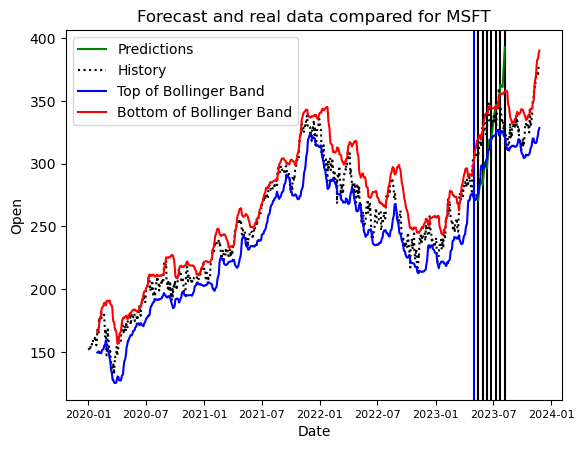

[I 2023-11-26 23:16:26,864] Trial 6 finished with value: 21.5 and parameters: {'n_a': 64, 'learning_rate': 0.003701978983307311, 'seq_len': 62}. Best is trial 3 with value: 11.0.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/10
21/21 [==============================] - 3s 62ms/step - loss: 0.0355 - mean_absolute_error: 0.1994
Epoch 2/10
21/21 [==============================] - 1s 67ms/step - loss: 0.0295 - mean_absolute_error: 0.1799
Epoch 3/10
21/21 [==============================] - 1s 65ms/step - loss: 0.0284 - mean_absolute_error: 0.1738
Epoch 4/10
21/21 [==============================] - 1s 64ms/step - loss: 0.0285 - mean_absolute_error: 0.1743
Epoch 5/10
21/21 [==============================] - 1s 66ms/step - loss: 0.0285 - mean_absolute_error: 0.1724
Epoch 6/10
21/21 [==============================] - 2s 75ms/step - loss: 0.0284 - mean_absolute_error: 0.1735
Epoch 7/10
21/21 [==============================] - 1s 69ms/step - loss: 0.0282 - mean_absolute_error: 0.1722
Epoch 8/10
21/21 [==============================] - 1s 71ms/step - loss: 0.0275 - mean_absolute_error: 0.1692
Epoch 9/10
21/21 [==============================] - 1s 71ms/step - loss:

23/23 [==============================] - 2s 74ms/step - loss: 0.0294 - mean_absolute_error: 0.1718
Epoch 6/10
23/23 [==============================] - 2s 69ms/step - loss: 0.0302 - mean_absolute_error: 0.1759
Epoch 7/10
23/23 [==============================] - 2s 77ms/step - loss: 0.0295 - mean_absolute_error: 0.1713
Epoch 8/10
23/23 [==============================] - 2s 72ms/step - loss: 0.0300 - mean_absolute_error: 0.1749
Epoch 9/10
23/23 [==============================] - 1s 63ms/step - loss: 0.0297 - mean_absolute_error: 0.1730
Epoch 10/10
23/23 [==============================] - 2s 67ms/step - loss: 0.0297 - mean_absolute_error: 0.1719
forecast =ds
2023-07-31    348.505005
2023-08-07    353.254761
Name: y, dtype: float32
next_date = Timestamp('2023-08-07 00:00:00')

The Wallet gains per trade is (positive values = SELL)
[('SELL', 577.2), ('SELL', 218.0), ('SELL', 645.6), ('HOLD', 0.0), ('BUY', -135.3), ('HOLD', 0.0), ('BUY', -265.0)]

The Stock Value gains per trade is
[('SELL', 

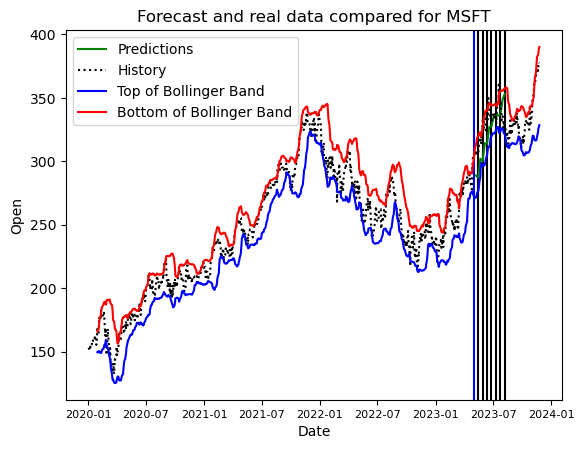

[I 2023-11-26 23:18:42,152] Trial 7 finished with value: 11.6 and parameters: {'n_a': 32, 'learning_rate': 0.008785127695211984, 'seq_len': 142}. Best is trial 3 with value: 11.0.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/10
21/21 [==============================] - 8s 310ms/step - loss: 0.1168 - mean_absolute_error: 0.3899
Epoch 2/10
21/21 [==============================] - 7s 325ms/step - loss: 0.1047 - mean_absolute_error: 0.3692
Epoch 3/10
21/21 [==============================] - 7s 338ms/step - loss: 0.0989 - mean_absolute_error: 0.3595
Epoch 4/10
21/21 [==============================] - 7s 335ms/step - loss: 0.0966 - mean_absolute_error: 0.3547
Epoch 5/10
21/21 [==============================] - 7s 355ms/step - loss: 0.0935 - mean_absolute_error: 0.3491
Epoch 6/10
21/21 [==============================] - 7s 337ms/step - loss: 0.0919 - mean_absolute_error: 0.3462
Epoch 7/10
21/21 [==============================] - 7s 329ms/step - loss: 0.0900 - mean_absolute_error: 0.3432
Epoch 8/10
21/21 [==============================] - 7s 342ms/step - loss: 0.0883 - mean_absolute_error: 0.3400
Epoch 9/10
21/21 [==============================] - 7s 330ms/ste

23/23 [==============================] - 7s 323ms/step - loss: 0.0732 - mean_absolute_error: 0.3128
Epoch 5/10
23/23 [==============================] - 7s 322ms/step - loss: 0.0720 - mean_absolute_error: 0.3110
Epoch 6/10
23/23 [==============================] - 6s 264ms/step - loss: 0.0723 - mean_absolute_error: 0.3117
Epoch 7/10
23/23 [==============================] - 7s 318ms/step - loss: 0.0717 - mean_absolute_error: 0.3105
Epoch 8/10
23/23 [==============================] - 7s 296ms/step - loss: 0.0714 - mean_absolute_error: 0.3099
Epoch 9/10
23/23 [==============================] - 7s 318ms/step - loss: 0.0716 - mean_absolute_error: 0.3104
Epoch 10/10
23/23 [==============================] - 7s 303ms/step - loss: 0.0706 - mean_absolute_error: 0.3086
forecast =ds
2023-07-31    283.281219
2023-08-07    269.620148
Name: y, dtype: float32
next_date = Timestamp('2023-08-07 00:00:00')

The Wallet gains per trade is (positive values = SELL)
[('SELL', 1986.7), ('SELL', 1071.0), ('SELL',

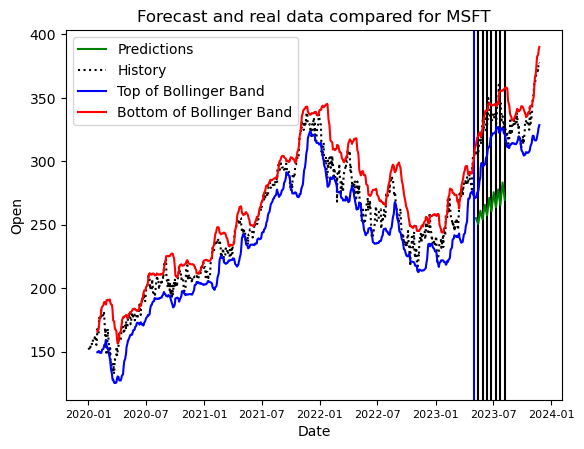

[I 2023-11-26 23:27:33,871] Trial 8 finished with value: 64.1 and parameters: {'n_a': 128, 'learning_rate': 0.0011487498604318615, 'seq_len': 140}. Best is trial 3 with value: 11.0.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/10
22/22 [==============================] - 3s 50ms/step - loss: 0.0996 - mean_absolute_error: 0.3665
Epoch 2/10
22/22 [==============================] - 1s 47ms/step - loss: 0.0875 - mean_absolute_error: 0.3446
Epoch 3/10
22/22 [==============================] - 1s 48ms/step - loss: 0.0819 - mean_absolute_error: 0.3329
Epoch 4/10
22/22 [==============================] - 1s 49ms/step - loss: 0.0790 - mean_absolute_error: 0.3274
Epoch 5/10
22/22 [==============================] - 1s 49ms/step - loss: 0.0775 - mean_absolute_error: 0.3237
Epoch 6/10
22/22 [==============================] - 1s 46ms/step - loss: 0.0754 - mean_absolute_error: 0.3203
Epoch 7/10
22/22 [==============================] - 1s 53ms/step - loss: 0.0746 - mean_absolute_error: 0.3172
Epoch 8/10
22/22 [==============================] - 1s 53ms/step - loss: 0.0729 - mean_absolute_error: 0.3144
Epoch 9/10
22/22 [==============================] - 1s 62ms/step - loss:

24/24 [==============================] - 1s 46ms/step - loss: 0.0595 - mean_absolute_error: 0.2823
Epoch 6/10
24/24 [==============================] - 1s 47ms/step - loss: 0.0584 - mean_absolute_error: 0.2801
Epoch 7/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0590 - mean_absolute_error: 0.2820
Epoch 8/10
24/24 [==============================] - 1s 54ms/step - loss: 0.0595 - mean_absolute_error: 0.2829
Epoch 9/10
24/24 [==============================] - 1s 62ms/step - loss: 0.0588 - mean_absolute_error: 0.2817
Epoch 10/10
24/24 [==============================] - 1s 59ms/step - loss: 0.0588 - mean_absolute_error: 0.2816
forecast =ds
2023-07-31    304.816376
2023-08-07    289.693878
Name: y, dtype: float32
next_date = Timestamp('2023-08-07 00:00:00')

The Wallet gains per trade is (positive values = SELL)
[('SELL', 1802.3), ('SELL', 1256.7), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0)]

The Stock Value gains per trade is
[('SELL', -179

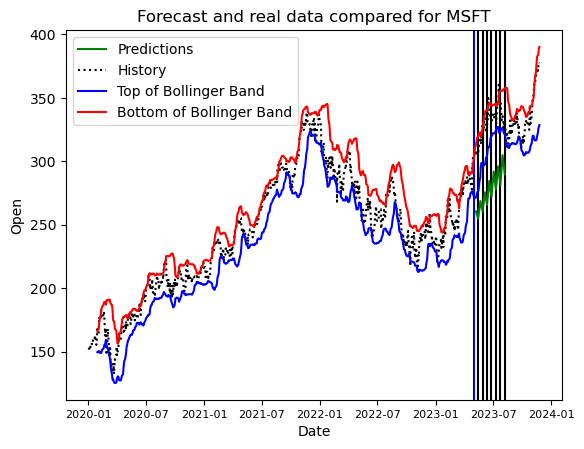

[I 2023-11-26 23:29:31,480] Trial 9 finished with value: 52.0 and parameters: {'n_a': 32, 'learning_rate': 0.002067418275056319, 'seq_len': 104}. Best is trial 3 with value: 11.0.



Number of finished trials:  10
Best trial:
  MAE:  11.0
  Params: 
    n_a: 128
    learning_rate: 0.006000075993611755
    seq_len: 165


In [9]:
n_a, learning_rate, seq_len = optuna_search(10, stateful = False, epochs = 10)

The best run was with the parameters {'n_a': 128, 'learning_rate': 0.006000075993611755, 'seq_len': 165}
resulting in MAE of: 11.0 in the validation set.

However, a more simple model with the parameters {'n_a': 32, 'learning_rate': 0.008785127695211984, 'seq_len': 142}
resulted in MAE of: 11.6 in the validation set.

Another notable trial is one with the parameters {'n_a': 32, 'learning_rate': 0.008425518534432113, 'seq_len': 68}
resulting in MAE of: 12.5 in the validation set.

Test the best parameters with stateful = True

[I 2023-11-26 23:31:52,368] A new study created in memory with name: no-name-ca800f93-f4ee-4c01-a927-bbb71265489a


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/10
673/673 [==============================] - 53s 76ms/step - loss: 0.0973 - mean_absolute_error: 0.3541
Epoch 2/10
673/673 [==============================] - 34s 51ms/step - loss: 0.0687 - mean_absolute_error: 0.3000
Epoch 3/10
673/673 [==============================] - 31s 46ms/step - loss: 0.0570 - mean_absolute_error: 0.2744
Epoch 4/10
673/673 [==============================] - 30s 45ms/step - loss: 0.0486 - mean_absolute_error: 0.2528
Epoch 5/10
673/673 [==============================] - 28s 42ms/step - loss: 0.0433 - mean_absolute_error: 0.2368
Epoch 6/10
673/673 [==============================] - 30s 44ms/step - loss: 0.0389 - mean_absolute_error: 0.2221
Epoch 7/10
673/673 [==============================] - 30s 45ms/step - loss: 0.0359 - mean_absolute_error: 0.2114
Epoch 8/10
673/673 [==============================] - 30s 45ms/step - loss: 0.0345 - mean_absolute_error: 0.2056
Epoch 9/10
673/673 [============================

Epoch 1/10
730/730 [==============================] - 31s 42ms/step - loss: 0.0321 - mean_absolute_error: 0.1928
Epoch 2/10
730/730 [==============================] - 31s 43ms/step - loss: 0.0324 - mean_absolute_error: 0.1924
Epoch 3/10
730/730 [==============================] - 29s 40ms/step - loss: 0.0320 - mean_absolute_error: 0.1914
Epoch 4/10
730/730 [==============================] - 29s 40ms/step - loss: 0.0317 - mean_absolute_error: 0.1897
Epoch 5/10
730/730 [==============================] - 31s 43ms/step - loss: 0.0316 - mean_absolute_error: 0.1896
Epoch 6/10
730/730 [==============================] - 31s 43ms/step - loss: 0.0319 - mean_absolute_error: 0.1913
Epoch 7/10
730/730 [==============================] - 31s 43ms/step - loss: 0.0318 - mean_absolute_error: 0.1904
Epoch 8/10
730/730 [==============================] - 31s 42ms/step - loss: 0.0321 - mean_absolute_error: 0.1915
Epoch 9/10
730/730 [==============================] - 30s 41ms/step - loss: 0.0316 - mean_absolu

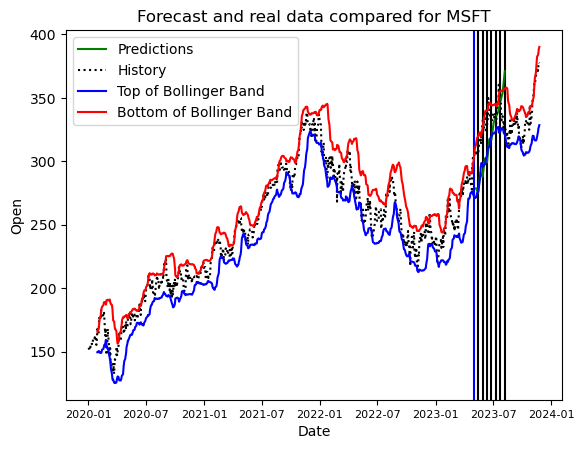

[I 2023-11-27 00:09:55,079] Trial 0 finished with value: 18.0 and parameters: {'n_a': 128, 'learning_rate': 0.006000075993611755, 'seq_len': 165}. Best is trial 0 with value: 18.0.



Number of finished trials:  1
Best trial:
  MAE:  18.0
  Params: 
    n_a: 128
    learning_rate: 0.006000075993611755
    seq_len: 165


In [10]:
n_a, learning_rate, seq_len = optuna_search(1, 
                                            n_a_list = [n_a],
                                            lr_range = (learning_rate, learning_rate),
                                            seq_len_range = (seq_len, seq_len),
                                            stateful = True, 
                                            epochs = 10)

With the stateful mode on, the hyperparameters may be some re-tuning.

When stateful = False, the LSTM layer resets its internal states (cell state and hidden state) at the end of each batch during training. This means that the LSTM treats each batch independently and does not retain any information from the previous batch. Consequently, the LSTM does not consider the temporal dependencies between batches, which may be crucial in capturing patterns in stock price data.

When stateful = True, the LSTM layer preserves its internal state between batches and the batch size is set to 1. This allows the LSTM to retain the memory of the previous sequence's hidden state and cell state, which captures the temporal dependencies and patterns in the stock price data. By doing so, the LSTM can remember the information from the previous sequences and use it as a context when processing the current sequence.

Another approach at hyperparameter tuning could be to experiment with various shifts between each subsequent sequence. Larger shifts would reduce redundancy and might be better depending on the patterns that need to be captured. It could be useful if underlying patterns in the data change significantly over time or if there are specific events or trends that occur within a larger time frame. However, the number of trading examples will be reduced. It is a trade-off between having more diverse, non-overlapping sequences and having a larger number of training examples.

Re-run a hyperparameter search on a smaller window but with stateful = True

[I 2023-11-27 01:01:59,589] A new study created in memory with name: no-name-75954bde-4f66-4a47-99e5-6b7f373622b7


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/20
727/727 [==============================] - 18s 23ms/step - loss: 0.1438 - mean_absolute_error: 0.4396
Epoch 2/20
727/727 [==============================] - 16s 21ms/step - loss: 0.1438 - mean_absolute_error: 0.4396
Epoch 3/20
727/727 [==============================] - 16s 22ms/step - loss: 0.1438 - mean_absolute_error: 0.4397
Epoch 4/20
727/727 [==============================] - 17s 23ms/step - loss: 0.1438 - mean_absolute_error: 0.4396
Epoch 5/20
727/727 [==============================] - 17s 23ms/step - loss: 0.1438 - mean_absolute_error: 0.4396
Epoch 6/20
727/727 [==============================] - 16s 23ms/step - loss: 0.1438 - mean_absolute_error: 0.4396
Epoch 7/20
727/727 [==============================] - 17s 23ms/step - loss: 0.1438 - mean_absolute_error: 0.4396
Epoch 8/20
727/727 [==============================] - 16s 22ms/step - loss: 0.1438 - mean_absolute_error: 0.4396
Epoch 9/20
727/727 [============================

756/756 [==============================] - 17s 23ms/step - loss: 0.1440 - mean_absolute_error: 0.4412
Epoch 7/20
756/756 [==============================] - 17s 23ms/step - loss: 0.1440 - mean_absolute_error: 0.4412
Epoch 8/20
756/756 [==============================] - 17s 23ms/step - loss: 0.1440 - mean_absolute_error: 0.4412
Epoch 9/20
756/756 [==============================] - 17s 23ms/step - loss: 0.1440 - mean_absolute_error: 0.4412
Epoch 10/20
756/756 [==============================] - 18s 24ms/step - loss: 0.1440 - mean_absolute_error: 0.4412
Epoch 11/20
756/756 [==============================] - 17s 22ms/step - loss: 0.1440 - mean_absolute_error: 0.4412
Epoch 12/20
756/756 [==============================] - 18s 23ms/step - loss: 0.1440 - mean_absolute_error: 0.4412
Epoch 13/20
756/756 [==============================] - 18s 23ms/step - loss: 0.1440 - mean_absolute_error: 0.4412
Epoch 14/20
756/756 [==============================] - 18s 24ms/step - loss: 0.1440 - mean_absolute_err

784/784 [==============================] - 18s 23ms/step - loss: 0.1549 - mean_absolute_error: 0.4563
Epoch 13/20
784/784 [==============================] - 19s 24ms/step - loss: 0.1549 - mean_absolute_error: 0.4563
Epoch 14/20
784/784 [==============================] - 18s 23ms/step - loss: 0.1549 - mean_absolute_error: 0.4563
Epoch 15/20
784/784 [==============================] - 18s 23ms/step - loss: 0.1549 - mean_absolute_error: 0.4563
Epoch 16/20
784/784 [==============================] - 18s 22ms/step - loss: 0.1550 - mean_absolute_error: 0.4563
Epoch 17/20
784/784 [==============================] - 18s 23ms/step - loss: 0.1549 - mean_absolute_error: 0.4563
Epoch 18/20
784/784 [==============================] - 18s 24ms/step - loss: 0.1549 - mean_absolute_error: 0.4563
Epoch 19/20
784/784 [==============================] - 18s 23ms/step - loss: 0.1549 - mean_absolute_error: 0.4563
Epoch 20/20
784/784 [==============================] - 7s 9ms/step
forecast =ds
2023-07-31    248.31

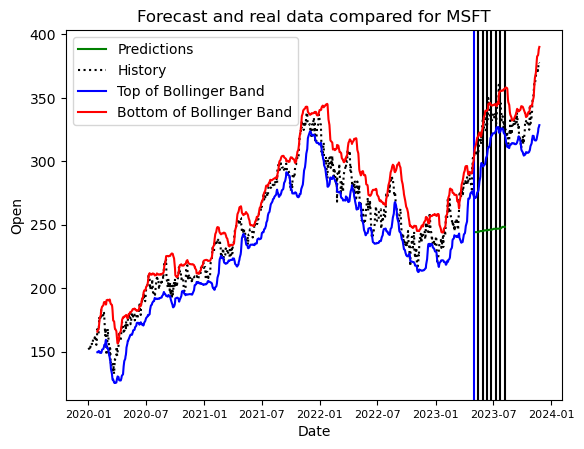

[I 2023-11-27 01:44:00,269] Trial 0 finished with value: 83.2 and parameters: {'n_a': 64, 'learning_rate': 0.003506575410186656, 'seq_len': 111}. Best is trial 0 with value: 83.2.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/20
732/732 [==============================] - 20s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 2/20
732/732 [==============================] - 17s 23ms/step - loss: nan - mean_absolute_error: nan
Epoch 3/20
732/732 [==============================] - 17s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 4/20
732/732 [==============================] - 17s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 5/20
732/732 [==============================] - 17s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 6/20
732/732 [==============================] - 18s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 7/20
732/732 [==============================] - 17s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 8/20
732/732 [==============================] - 18s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 9/20
732/732 [==============================] - 17s 23ms/step - loss: nan - mean_absolute_

761/761 [==============================] - 18s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 11/20
761/761 [==============================] - 18s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 12/20
761/761 [==============================] - 18s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 13/20
761/761 [==============================] - 18s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 14/20
761/761 [==============================] - 18s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 15/20
761/761 [==============================] - 18s 23ms/step - loss: nan - mean_absolute_error: nan
Epoch 16/20
761/761 [==============================] - 18s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 17/20
761/761 [==============================] - 18s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 18/20
761/761 [==============================] - 18s 24ms/step - loss: nan - mean_absolute_error: nan
Epoch 19/20
761/761 [===================

789/789 [==============================] - 8s 10ms/step
forecast =ds
2023-07-31   NaN
2023-08-07   NaN
Name: y, dtype: float32
next_date = Timestamp('2023-08-07 00:00:00')

The Wallet gains per trade is (positive values = SELL)
[('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0)]

The Stock Value gains per trade is
[('HOLD', 21.2), ('HOLD', 266.9), ('HOLD', -66.2), ('HOLD', 51.2), ('HOLD', 8.8), ('HOLD', 112.0), ('HOLD', -174.1)]

Stock + Wallet value variation after trading: 
[('HOLD', 21.2), ('HOLD', 266.9), ('HOLD', -66.2), ('HOLD', 51.2), ('HOLD', 8.8), ('HOLD', 112.0), ('HOLD', -174.1)]

Stock + Wallet Gains related to stock traded: 
[('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0)]
with sum of 0

Initial stock (Quantity = 10) value on 2023-05-01 00:00:00: 3050.3

Initial stock (Quantity = 10) value on 2023-08-01 00:00:00: 3270.1

Final stock (Quantity = 10) value on 2023-08-01 00:00:00:

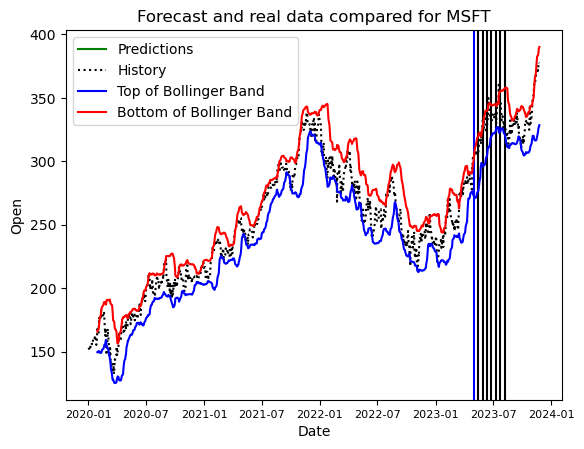

[W 2023-11-27 02:27:43,868] Trial 1 failed with parameters: {'n_a': 128, 'learning_rate': 0.009197350992568125, 'seq_len': 106} because of the following error: The value nan is not acceptable..
[W 2023-11-27 02:27:43,870] Trial 1 failed with value nan.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/20
770/770 [==============================] - 14s 15ms/step - loss: 0.1172 - mean_absolute_error: 0.3927
Epoch 2/20
770/770 [==============================] - 11s 15ms/step - loss: 0.0977 - mean_absolute_error: 0.3535
Epoch 3/20
770/770 [==============================] - 11s 15ms/step - loss: 0.0904 - mean_absolute_error: 0.3368
Epoch 4/20
770/770 [==============================] - 12s 15ms/step - loss: 0.0888 - mean_absolute_error: 0.3315
Epoch 5/20
770/770 [==============================] - 11s 14ms/step - loss: 0.0833 - mean_absolute_error: 0.3178
Epoch 6/20
770/770 [==============================] - 11s 14ms/step - loss: 0.0810 - mean_absolute_error: 0.3109
Epoch 7/20
770/770 [==============================] - 11s 14ms/step - loss: 0.0794 - mean_absolute_error: 0.3067
Epoch 8/20
770/770 [==============================] - 11s 14ms/step - loss: 0.0793 - mean_absolute_error: 0.3042
Epoch 9/20
770/770 [============================

799/799 [==============================] - 11s 14ms/step - loss: 0.0665 - mean_absolute_error: 0.2605
Epoch 7/20
799/799 [==============================] - 12s 14ms/step - loss: 0.0668 - mean_absolute_error: 0.2602
Epoch 8/20
799/799 [==============================] - 12s 15ms/step - loss: 0.0668 - mean_absolute_error: 0.2606
Epoch 9/20
799/799 [==============================] - 12s 15ms/step - loss: 0.0670 - mean_absolute_error: 0.2613
Epoch 10/20
799/799 [==============================] - 12s 15ms/step - loss: 0.0666 - mean_absolute_error: 0.2595
Epoch 11/20
799/799 [==============================] - 12s 15ms/step - loss: 0.0670 - mean_absolute_error: 0.2596
Epoch 12/20
799/799 [==============================] - 12s 15ms/step - loss: 0.0665 - mean_absolute_error: 0.2582
Epoch 13/20
799/799 [==============================] - 12s 15ms/step - loss: 0.0666 - mean_absolute_error: 0.2590
Epoch 14/20
799/799 [==============================] - 12s 15ms/step - loss: 0.0665 - mean_absolute_err

827/827 [==============================] - 12s 14ms/step - loss: 0.0678 - mean_absolute_error: 0.2618
Epoch 13/20
827/827 [==============================] - 12s 15ms/step - loss: 0.0680 - mean_absolute_error: 0.2610
Epoch 14/20
827/827 [==============================] - 12s 15ms/step - loss: 0.0681 - mean_absolute_error: 0.2619
Epoch 15/20
827/827 [==============================] - 11s 13ms/step - loss: 0.0674 - mean_absolute_error: 0.2585
Epoch 16/20
827/827 [==============================] - 12s 15ms/step - loss: 0.0685 - mean_absolute_error: 0.2632
Epoch 17/20
827/827 [==============================] - 12s 15ms/step - loss: 0.0681 - mean_absolute_error: 0.2611
Epoch 18/20
827/827 [==============================] - 12s 15ms/step - loss: 0.0673 - mean_absolute_error: 0.2588
Epoch 19/20
827/827 [==============================] - 12s 15ms/step - loss: 0.0679 - mean_absolute_error: 0.2603
Epoch 20/20
827/827 [==============================] - 5s 5ms/step
forecast =ds
2023-07-31    351.99

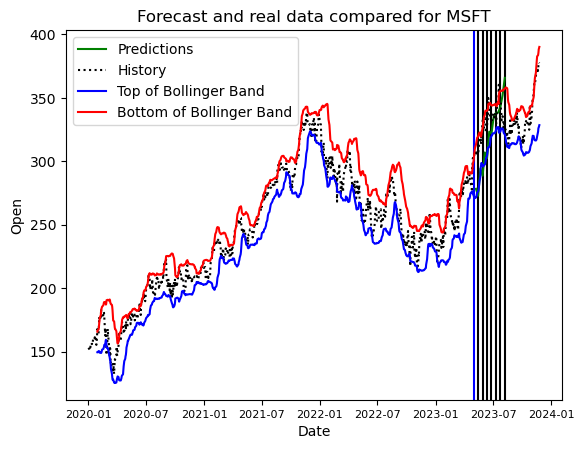

[I 2023-11-27 02:56:07,612] Trial 2 finished with value: 16.5 and parameters: {'n_a': 32, 'learning_rate': 0.008425518534432113, 'seq_len': 68}. Best is trial 2 with value: 16.5.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/20
673/673 [==============================] - 26s 35ms/step - loss: 0.1206 - mean_absolute_error: 0.3939
Epoch 2/20
673/673 [==============================] - 23s 34ms/step - loss: 0.0909 - mean_absolute_error: 0.3458
Epoch 3/20
673/673 [==============================] - 23s 35ms/step - loss: 0.0773 - mean_absolute_error: 0.3191
Epoch 4/20
673/673 [==============================] - 24s 36ms/step - loss: 0.0671 - mean_absolute_error: 0.2973
Epoch 5/20
673/673 [==============================] - 23s 35ms/step - loss: 0.0595 - mean_absolute_error: 0.2799
Epoch 6/20
673/673 [==============================] - 24s 35ms/step - loss: 0.0525 - mean_absolute_error: 0.2628
Epoch 7/20
673/673 [==============================] - 23s 34ms/step - loss: 0.0467 - mean_absolute_error: 0.2461
Epoch 8/20
673/673 [==============================] - 23s 34ms/step - loss: 0.0421 - mean_absolute_error: 0.2316
Epoch 9/20
673/673 [============================

702/702 [==============================] - 24s 34ms/step - loss: 0.0341 - mean_absolute_error: 0.2044
Epoch 7/20
702/702 [==============================] - 25s 36ms/step - loss: 0.0335 - mean_absolute_error: 0.2017
Epoch 8/20
702/702 [==============================] - 24s 35ms/step - loss: 0.0338 - mean_absolute_error: 0.2044
Epoch 9/20
702/702 [==============================] - 25s 35ms/step - loss: 0.0337 - mean_absolute_error: 0.2032
Epoch 10/20
702/702 [==============================] - 25s 35ms/step - loss: 0.0337 - mean_absolute_error: 0.2024
Epoch 11/20
702/702 [==============================] - 24s 34ms/step - loss: 0.0335 - mean_absolute_error: 0.2023
Epoch 12/20
702/702 [==============================] - 24s 35ms/step - loss: 0.0333 - mean_absolute_error: 0.2006
Epoch 13/20
702/702 [==============================] - 24s 35ms/step - loss: 0.0336 - mean_absolute_error: 0.2018
Epoch 14/20
702/702 [==============================] - 25s 35ms/step - loss: 0.0337 - mean_absolute_err

730/730 [==============================] - 25s 34ms/step - loss: 0.0335 - mean_absolute_error: 0.1984
Epoch 13/20
730/730 [==============================] - 26s 35ms/step - loss: 0.0336 - mean_absolute_error: 0.2006
Epoch 14/20
730/730 [==============================] - 25s 34ms/step - loss: 0.0339 - mean_absolute_error: 0.2013
Epoch 15/20
730/730 [==============================] - 26s 35ms/step - loss: 0.0334 - mean_absolute_error: 0.1982
Epoch 16/20
730/730 [==============================] - 25s 34ms/step - loss: 0.0338 - mean_absolute_error: 0.2008
Epoch 17/20
730/730 [==============================] - 25s 34ms/step - loss: 0.0339 - mean_absolute_error: 0.2012
Epoch 18/20
730/730 [==============================] - 26s 35ms/step - loss: 0.0332 - mean_absolute_error: 0.1978
Epoch 19/20
730/730 [==============================] - 25s 35ms/step - loss: 0.0337 - mean_absolute_error: 0.1995
Epoch 20/20
730/730 [==============================] - 10s 13ms/step
forecast =ds
2023-07-31    350.

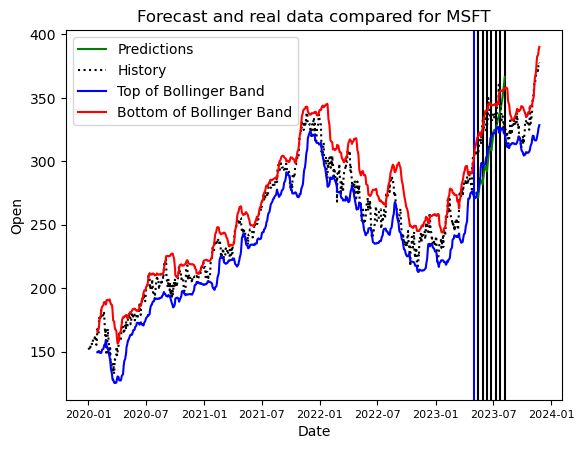

[I 2023-11-27 03:54:50,575] Trial 3 finished with value: 22.5 and parameters: {'n_a': 128, 'learning_rate': 0.006000075993611755, 'seq_len': 165}. Best is trial 2 with value: 16.5.


current_date = Timestamp('2023-05-01 00:00:00')
Epoch 1/20
764/764 [==============================] - 13s 15ms/step - loss: 0.1273 - mean_absolute_error: 0.4113
Epoch 2/20
764/764 [==============================] - 12s 15ms/step - loss: 0.1094 - mean_absolute_error: 0.3790
Epoch 3/20
764/764 [==============================] - 12s 16ms/step - loss: 0.1026 - mean_absolute_error: 0.3657
Epoch 4/20
764/764 [==============================] - 12s 16ms/step - loss: 0.0981 - mean_absolute_error: 0.3563
Epoch 5/20
764/764 [==============================] - 12s 16ms/step - loss: 0.0948 - mean_absolute_error: 0.3494
Epoch 6/20
764/764 [==============================] - 12s 16ms/step - loss: 0.0938 - mean_absolute_error: 0.3463
Epoch 7/20
764/764 [==============================] - 12s 16ms/step - loss: 0.0902 - mean_absolute_error: 0.3400
Epoch 8/20
764/764 [==============================] - 12s 16ms/step - loss: 0.0893 - mean_absolute_error: 0.3375
Epoch 9/20
764/764 [============================

793/793 [==============================] - 13s 16ms/step - loss: 0.0700 - mean_absolute_error: 0.2831
Epoch 7/20
793/793 [==============================] - 12s 16ms/step - loss: 0.0688 - mean_absolute_error: 0.2818
Epoch 8/20
793/793 [==============================] - 12s 15ms/step - loss: 0.0687 - mean_absolute_error: 0.2796
Epoch 9/20
793/793 [==============================] - 12s 15ms/step - loss: 0.0688 - mean_absolute_error: 0.2812
Epoch 10/20
793/793 [==============================] - 13s 16ms/step - loss: 0.0692 - mean_absolute_error: 0.2822
Epoch 11/20
793/793 [==============================] - 12s 15ms/step - loss: 0.0688 - mean_absolute_error: 0.2809
Epoch 12/20
793/793 [==============================] - 12s 15ms/step - loss: 0.0690 - mean_absolute_error: 0.2809
Epoch 13/20
793/793 [==============================] - 13s 16ms/step - loss: 0.0691 - mean_absolute_error: 0.2805
Epoch 14/20
793/793 [==============================] - 13s 16ms/step - loss: 0.0684 - mean_absolute_err

821/821 [==============================] - 13s 16ms/step - loss: 0.0671 - mean_absolute_error: 0.2707
Epoch 13/20
821/821 [==============================] - 12s 15ms/step - loss: 0.0669 - mean_absolute_error: 0.2711
Epoch 14/20
821/821 [==============================] - 13s 16ms/step - loss: 0.0666 - mean_absolute_error: 0.2684
Epoch 15/20
821/821 [==============================] - 13s 16ms/step - loss: 0.0667 - mean_absolute_error: 0.2682
Epoch 16/20
821/821 [==============================] - 13s 16ms/step - loss: 0.0675 - mean_absolute_error: 0.2728
Epoch 17/20
821/821 [==============================] - 13s 16ms/step - loss: 0.0676 - mean_absolute_error: 0.2738
Epoch 18/20
821/821 [==============================] - 13s 16ms/step - loss: 0.0669 - mean_absolute_error: 0.2709
Epoch 19/20
821/821 [==============================] - 13s 16ms/step - loss: 0.0676 - mean_absolute_error: 0.2731
Epoch 20/20
821/821 [==============================] - 5s 6ms/step
forecast =ds
2023-07-31    331.95

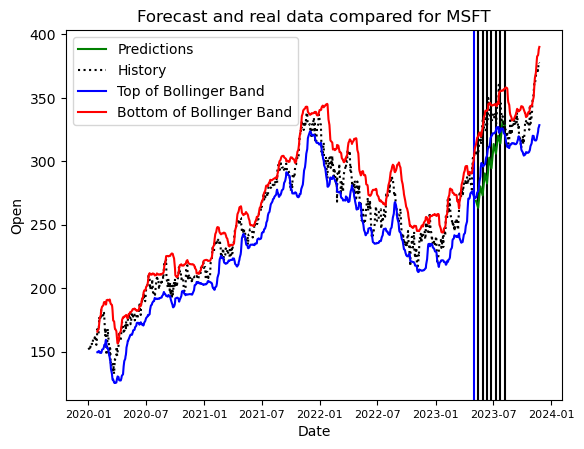

[I 2023-11-27 04:25:00,302] Trial 4 finished with value: 32.3 and parameters: {'n_a': 32, 'learning_rate': 0.006032942364042933, 'seq_len': 74}. Best is trial 2 with value: 16.5.



Number of finished trials:  5
Best trial:
  MAE:  16.5
  Params: 
    n_a: 32
    learning_rate: 0.008425518534432113
    seq_len: 68


In [15]:
n_a, learning_rate, seq_len = optuna_search(5, 
                                            n_a_list = [32, 64, 128],
                                            lr_range = (0.001, 0.01),
                                            seq_len_range = (60, 180),
                                            stateful = True, 
                                            epochs = 20)

Set the time parameters to test the model

In [16]:
start_date = pd.to_datetime('2023-08-01') # Predictions begin after this date
end_date = pd.to_datetime('2023-11-26') # Predictions end after this date

interval = 7 # in days
periods = 2 # A recommendation is made every periods*interval days

Set the model parameters

In [25]:
args = defaultdict(int)

arguments = {'seq_len': 165,
             'n_features': 1,
             'learning_rate': 0.006,
             'loss': 'huber',
             'decay': 0.99,
             'epochs': 10,
             'n_a': 128,
             'include_dates': False,
             'stateful': False,
             'difference': False}

for key, value in arguments.items():
    args[key] = value

Create a forecaster object

In [26]:
clairvoyant = forecaster('LSTM', args)

Create a recommender object

In [27]:
recommend = recommender(oracle = clairvoyant,
                        initial_stock = initial_stock, 
                        max_trade = max_trade,
                        intensity = intensity,
                        min_delta = min_delta)

Perform the recommendation

current_date = Timestamp('2023-08-01 00:00:00')
Epoch 1/10
23/23 [==============================] - 6s 176ms/step - loss: 0.0443 - mean_absolute_error: 0.2260
Epoch 2/10
23/23 [==============================] - 4s 176ms/step - loss: 0.0301 - mean_absolute_error: 0.1803
Epoch 3/10
23/23 [==============================] - 4s 170ms/step - loss: 0.0297 - mean_absolute_error: 0.1795
Epoch 4/10
23/23 [==============================] - 4s 167ms/step - loss: 0.0294 - mean_absolute_error: 0.1760
Epoch 5/10
23/23 [==============================] - 4s 177ms/step - loss: 0.0292 - mean_absolute_error: 0.1759
Epoch 6/10
23/23 [==============================] - 4s 165ms/step - loss: 0.0291 - mean_absolute_error: 0.1752
Epoch 7/10
23/23 [==============================] - 3s 119ms/step - loss: 0.0290 - mean_absolute_error: 0.1735
Epoch 8/10
23/23 [==============================] - 3s 121ms/step - loss: 0.0293 - mean_absolute_error: 0.1758
Epoch 9/10
23/23 [==============================] - 3s 119ms/ste

24/24 [==============================] - 4s 177ms/step - loss: 0.0234 - mean_absolute_error: 0.1542
Epoch 5/10
24/24 [==============================] - 3s 120ms/step - loss: 0.0233 - mean_absolute_error: 0.1534
Epoch 6/10
24/24 [==============================] - 3s 116ms/step - loss: 0.0231 - mean_absolute_error: 0.1517
Epoch 7/10
24/24 [==============================] - 3s 115ms/step - loss: 0.0234 - mean_absolute_error: 0.1535
Epoch 8/10
24/24 [==============================] - 4s 149ms/step - loss: 0.0233 - mean_absolute_error: 0.1522
Epoch 9/10
24/24 [==============================] - 4s 169ms/step - loss: 0.0236 - mean_absolute_error: 0.1557
Epoch 10/10
24/24 [==============================] - 4s 161ms/step - loss: 0.0234 - mean_absolute_error: 0.1541
forecast =ds
2023-10-31    329.129578
2023-11-07    329.436707
Name: y, dtype: float32
next_date = Timestamp('2023-11-07 00:00:00')
current_date = Timestamp('2023-11-07 00:00:00')
Epoch 1/10
25/25 [==============================] - 4

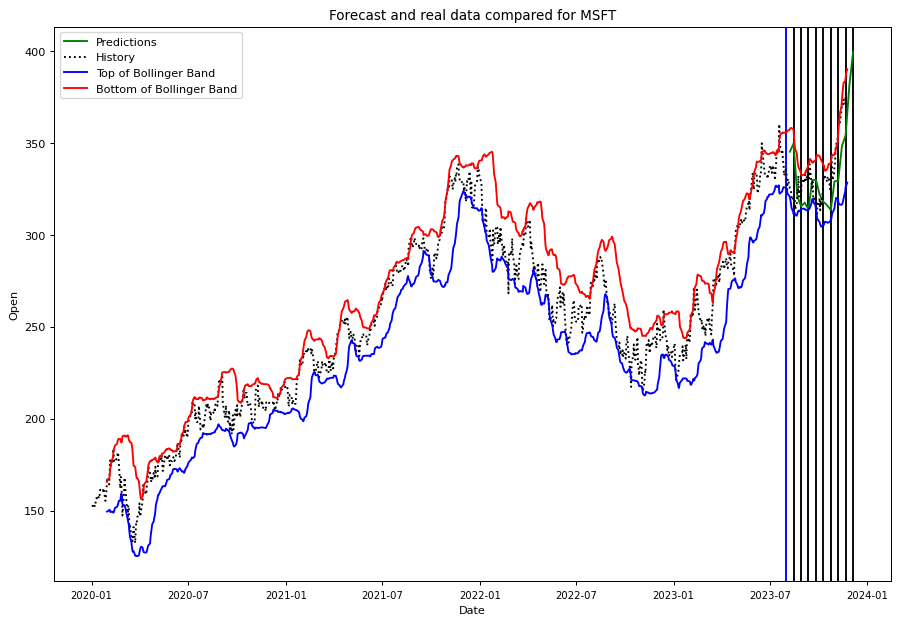

In [28]:
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':90, 'font.size':9})
args = (history, start_date, end_date, periods, interval)
recommend(args) # performs the recommendation